# On récupère les données

In [1]:
import pandas as pd
import numpy as np
import json
import re
import time
import datetime
from pickle import Pickler as pck
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor  as vif 


pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 200000)

dfCust = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_customers_dataset.csv", sep = ',')
dfGeo = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_geolocation_dataset.csv", sep = ',')
dfItem = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_order_items_dataset.csv", sep = ',')
dfPaym = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_order_payments_dataset.csv", sep = ',')
dfReview = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_order_reviews_dataset.csv", sep = ',')
dfOrders = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_orders_dataset.csv", sep = ',')
dfProd = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_products_dataset.csv", sep = ',')
dfSeller = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/olist_sellers_dataset.csv", sep = ',')
dfTransl = pd.read_csv("/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/product_category_name_translation.csv", sep = ',')

%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Permet d'afficher rapidement le tx de remplissage de la table:
def dropNa(df):
    '''
    permet d'afficher rapidement l'état de la table:
    -shape de la table
    -tx % de remplissage avant un 'dropna'
    '''
    print("\ninitial shape: ", df.shape)
    print("tx(%) NA:")
    print(df.count()/df.shape[0])

In [3]:
# Calcul de la distance entre 2 point repérés par des coordonnés GPS.
def dist(df1, df2):
    '''calcul la distance entre deux points repéré par des coordonnés GPS'''
    df1['geolocation_lat_x'] = df1['geolocation_lat_x']*np.pi/180
    df1['geolocation_lng_x'] = df1['geolocation_lng_x']*np.pi/180
    df2['geolocation_lat_y'] = df2['geolocation_lat_y']*np.pi/180
    df2['geolocation_lng_y'] = df2['geolocation_lng_y']*np.pi/180
    r = 6371000  # rayon de la terre en m

    alpha1 = (df1['geolocation_lat_x'] - df2['geolocation_lat_y']).to_numpy()
    alpha2 = (df1['geolocation_lng_x'] - df2['geolocation_lng_y']).to_numpy()

    a, b = r*np.cos(alpha1), r*np.sin(alpha1)
    c1 = np.sqrt((r-a)**2 + b**2)

    a, b = r*np.cos(alpha2), r*np.sin(alpha2)
    c2 = np.sqrt((r-a)**2 + b**2)

    d = np.sqrt(c1**2 + c2**2)

    d = 2*r*np.arcsin(d/(2*r))/1000

    return pd.Series(data=d, index=df1.index)

In [4]:
# On créé un indicateur permettant d'attribué une note comprise entre 0 et 1
# a la quantité d'information disponible sur le produit.
# on prend en entrée la quantité de photo et la taille du descriptif.
def note_prod(df):
    x = df['product_description_lenght'].to_numpy()
    y = df['product_photos_qty'].to_numpy()
    x = (x - x.mean())/x.std()
    y = (y - y.mean())/y.std()
    d = 1 - np.exp(-2*np.sqrt(x**2 + y**2))
    return pd.Series(data=d, index=df.index)

In [5]:
def featureSuppr(x):
    '''On garde les features pour lesquelles on obtient
    'inf' car il s'agit des features
    issues du OneHotEncoding. Lorsqu'une de ces
    variables bougent les autres ne bougent pas.
    Ce qui implique qu'elles sont parfaitment descriptibles
    par les autres, on botient donc un R² ~ 1
    et donc un vif -> inf'''
    viff = pd.DataFrame()
    viff['score'] = [vif(x.values, i) for i in range(x.shape[1])]
    viff['feature'] = x.columns
    viff = viff[viff['score'] != np.inf]
    viff = viff.sort_values('score', ascending=False)
    return viff['score'].iloc[0], viff['feature'].iloc[0]


def featureSelect(x):
    '''On supprime la feature qui est la plus corrélée
    puis on relance featureSuppr jusqu'a
    ce que plus aucune feature n'est un score supérieur
    supérieur à 2.5.'''
    x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
    while featureSuppr(x)[0] > 2:
        del(x[featureSuppr(x)[1]])
    return x.columns.tolist()

# On visualise l'état des tables

In [6]:
# On créé une liste de table
listeTable = [dfCust,
              dfGeo,
              dfItem,
              dfPaym,
              dfReview,
              dfOrders,
              dfProd,
              dfSeller,
              ]

# on visualise les tx de NA par table
# On constate que seule la table review comporte
# 2 colonnes comprenant beaucoup de NA.
for table in listeTable:
    dropNa(table)


initial shape:  (99441, 5)
tx(%) NA:
customer_id                 1.0
customer_unique_id          1.0
customer_zip_code_prefix    1.0
customer_city               1.0
customer_state              1.0
dtype: float64

initial shape:  (1000163, 5)
tx(%) NA:
geolocation_zip_code_prefix    1.0
geolocation_lat                1.0
geolocation_lng                1.0
geolocation_city               1.0
geolocation_state              1.0
dtype: float64

initial shape:  (112650, 7)
tx(%) NA:
order_id               1.0
order_item_id          1.0
product_id             1.0
seller_id              1.0
shipping_limit_date    1.0
price                  1.0
freight_value          1.0
dtype: float64

initial shape:  (103886, 5)
tx(%) NA:
order_id                1.0
payment_sequential      1.0
payment_type            1.0
payment_installments    1.0
payment_value           1.0
dtype: float64

initial shape:  (100000, 7)
tx(%) NA:
review_id                  1.00000
order_id                   1.00000
review_scor

# Modification de la table Geolocation

### visualisation de la table Geolocation

In [7]:
dfGeo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [8]:
# On constate qu'il n'y a pas de clef unique,
# car aucune colonne ne comporte que des valeurs
# uniques
dfGeo.nunique()/dfGeo.shape[0]

geolocation_zip_code_prefix    0.019012
geolocation_lat                0.717243
geolocation_lng                0.717496
geolocation_city               0.008010
geolocation_state              0.000027
dtype: float64

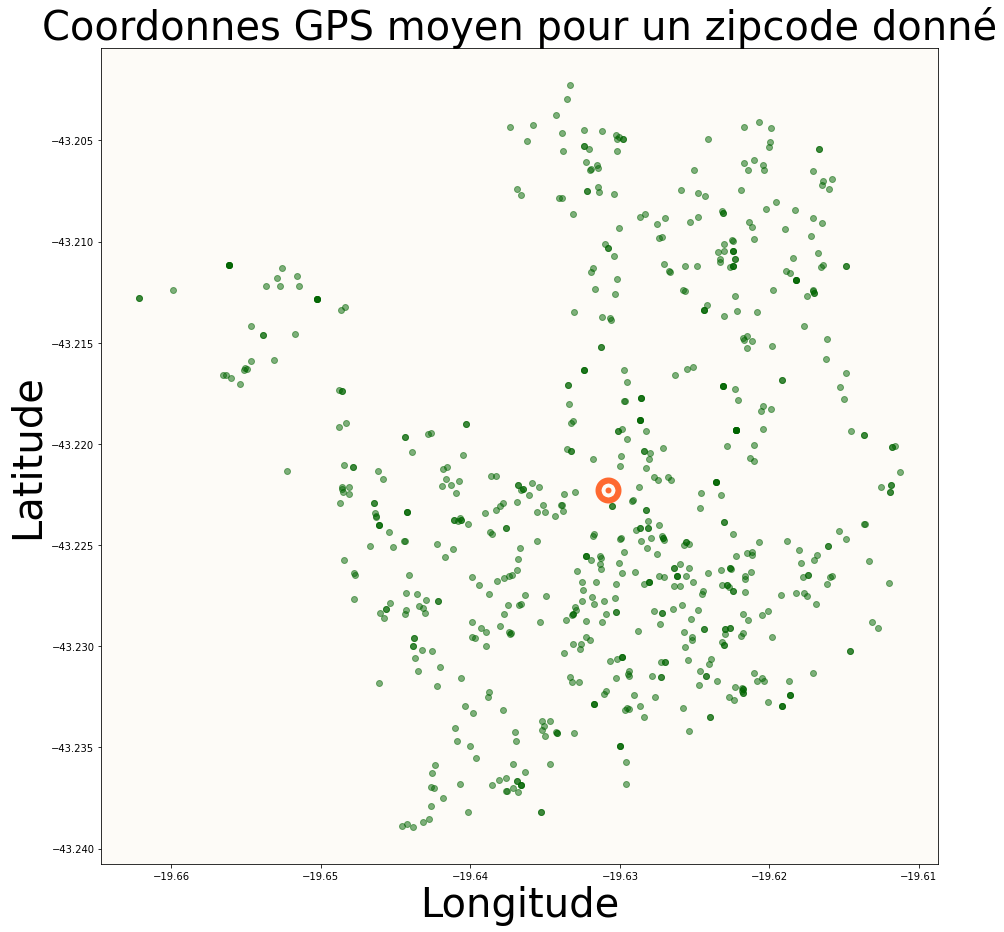

18:80: E501 line too long (135 > 79 characters)
22:80: E501 line too long (96 > 79 characters)
23:80: E501 line too long (113 > 79 characters)


In [2]:
# On a pas de clefs unique pour la table geolocation.
# On constate également que pour un zip code on a
# plusieurs coordonnées GPS possibles.
# On va transformer la table geolocation
# de manière a avoir q'une longitude et latitude
# par zipcode. En réalité il s'agit du centre de
# gravité (calcul de la moyenne de coordonnés par zipcode).
# La table compte également plusieurs 10 de million
# de lignes, cette opération devrait réduire sa taille.
# Exemple pour le zipcode  35900, on voit qu 'on a
# plusieurs point dans l'espace
# en prenant la moyenne on définit un adresse
# GPS pour les vendeurs et les clients.

# Ex: on filtre sur le zipcode: 35900
dfGeoEx = dfGeo[dfGeo['geolocation_zip_code_prefix'] == 35900]
# on calcul les coordonnés GPS moyens
dfGeoExf = dfGeoEx[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']].groupby('geolocation_zip_code_prefix').mean()

# On affiche les coordonnés moyen
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(dfGeoEx['geolocation_lat'], dfGeoEx['geolocation_lng'], color='darkgreen', alpha=0.5)
ax.scatter(dfGeoExf['geolocation_lat'], dfGeoExf['geolocation_lng'], color='orangered', linewidths=20, alpha=0.8)
ax.set_ylabel("Latitude", fontsize=40)
ax.set_xlabel("Longitude", fontsize=40)
ax.set_title("Coordonnes GPS moyen pour un zipcode donné", fontsize=40)
ax.patch.set_facecolor("wheat")
ax.patch.set_alpha(0.1)
plt.show()

In [10]:
# On modifie dfGeo.
dfGeo = dfGeo[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']].groupby('geolocation_zip_code_prefix', as_index=False).mean()
dfGeo.shape

(19015, 3)

2:80: E501 line too long (146 > 79 characters)


In [11]:
dfGeo.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


# Merge client et Geo

### Modification client

In [12]:
# On visualise la table client.
dfCust.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [13]:
# On ne garde pas 'customer city' car trop de valeur
# On ne garde pas 'customer state' car l'information
# est déjà comrise dans le zip code
# On va ne garder que le premier chiffre du zip code qui
# correspond a la region ce qui nous fera moins
# de valeurs. Les zipcode ne comptant que 4 chiffre
# commence en réalité par un 0. Ensuite
# plus tard fera du OneHoteEncoding

del(dfCust['customer_city'])
del(dfCust['customer_state'])

dfCust.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056


In [14]:
# Jointure sur entre dfCust et dfGeo pour
# récupérer les donnée GPS client
dfGeo = dfGeo.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'})
dfTot = pd.merge(dfCust, dfGeo, on="customer_zip_code_prefix")

3:80: E501 line too long (89 > 79 characters)


In [15]:
dfTot.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,-20.498489,-47.396929
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,-20.498489,-47.396929
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,-20.498489,-47.396929
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,-20.498489,-47.396929


# Merge dfCust et Order

### Modification Order

In [16]:
dfOrders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [17]:
dfOrders.count()/dfOrders.shape[0]

order_id                         1.000000
customer_id                      1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998391
order_delivered_carrier_date     0.982070
order_delivered_customer_date    0.970183
order_estimated_delivery_date    1.000000
dtype: float64

In [18]:
# On supprime les valeurs manquantes
dfOrders = dfOrders.dropna(how='any', axis=0)

In [19]:
# On convertit toutes les dates en timestamp
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    dfOrders[col] = pd.to_datetime(dfOrders[col], format="%Y-%m-%d %H:%M:%S")
    dfOrders[col] = [datetime.datetime.timestamp(dfOrders[col].iloc[i]) for i in range(dfOrders.shape[0])]

# on calcul le temps de livraison pour cahque ordre passé
# temps ecoulé entre la date d'achat et la date de reception
dfOrders['delivery_time'] = dfOrders['order_delivered_customer_date'] - dfOrders['order_purchase_timestamp']

# ne contient q'une seule valeur
del(dfOrders['order_status'])

<ipython-input-19-90722479053d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfOrders[col] = pd.to_datetime(dfOrders[col], format="%Y-%m-%d %H:%M:%S")
<ipython-input-19-90722479053d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfOrders[col] = [datetime.datetime.timestamp(dfOrders[col].iloc[i]) for i in range(dfOrders.shape[0])]
<ipython-input-19-90722479053d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [20]:
dfOrders.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
order_purchase_timestamp,1.00,1.00,1.00,1.00,1.00,-0.10
order_approved_at,1.00,1.00,1.00,1.00,1.00,-0.10
order_delivered_carrier_date,1.00,1.00,1.00,1.00,1.00,-0.09
order_delivered_customer_date,1.00,1.00,1.00,1.00,1.00,-0.04
order_estimated_delivery_date,1.00,1.00,1.00,1.00,1.00,-0.08
delivery_time,-0.10,-0.10,-0.09,-0.04,-0.08,1.00


In [21]:
# On ne conserve pas les colonnes trop corélées entre elles.
# On conserve les colonnes suivante
dfOrders = dfOrders[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time']]

3:80: E501 line too long (93 > 79 characters)


In [22]:
dfOrders.head(5)

,order_id,customer_id,order_purchase_timestamp,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1.506935e+09,728920.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,1.532458e+09,1190768.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,1.533710e+09,811660.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,1.511030e+09,1141236.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,1.518553e+09,248303.0


In [23]:
# On jointe les tables customer et order
dfTot = pd.merge(dfTot, dfOrders, on="customer_id")

In [24]:
dfTot.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,-20.498489,-47.396929,95261f608a64bbbe760a212b4d48a4ee,1.529086e+09,490279.0
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,-20.498489,-47.396929,9444fa2ab50a3f5af63b48be297eda24,1.504964e+09,794502.0
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,-20.498489,-47.396929,dceb8e88274c6f42a88a76ed979eb817,1.522059e+09,199326.0
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,-20.498489,-47.396929,6ee1cea1b2edcc713f83ebfbccbc57f9,1.532890e+09,418160.0


# Merge dfTot avec la table item

In [25]:
dfItem.count()/dfItem.shape[0]

order_id               1.0
order_item_id          1.0
product_id             1.0
seller_id              1.0
shipping_limit_date    1.0
price                  1.0
freight_value          1.0
dtype: float64

In [26]:
dfItem.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [27]:
# On constate qu'un client peut passer plusieurs ordre.
# Chaque ordre peut contenir plusieurs produits
# chaque produit peut contenir plusieurs items.

# On ne conserve pas cette date, on ne peut la comparer avec
# auune autre date.
del(dfItem['shipping_limit_date'])

In [28]:
dfItem.head(5)

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [29]:
# On merge avec la table item avec le reste
dfTot = pd.merge(dfTot, dfItem, on="order_id")
dfTot.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,-20.498489,-47.396929,95261f608a64bbbe760a212b4d48a4ee,1.529086e+09,490279.0,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,79.90,14.87
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,-20.498489,-47.396929,9444fa2ab50a3f5af63b48be297eda24,1.504964e+09,794502.0,1,83fe1ea6fd12c51fcd341a9968e65cc3,a3a38f4affed601eb87a97788c949667,44.90,17.60
3,702b62324327ccba20f1be3465426437,8b3d988f330c1d1c3332ccd440c147b7,14409,-20.498489,-47.396929,dceb8e88274c6f42a88a76ed979eb817,1.522059e+09,199326.0,1,ccb3df28522945422e24b108603a1d04,39d54ff918774174706fb065d7f9dc07,19.90,12.79
4,bdf997bae7ca819b0415f5174d6b4302,866755e25db620f8d7e81b351a15bb2f,14409,-20.498489,-47.396929,6ee1cea1b2edcc713f83ebfbccbc57f9,1.532890e+09,418160.0,1,cb7d42475660f66a519c76f55715cd32,bd0a1b0aadca9a83d9304f7e8ff5fbd5,63.90,13.11


# Merge dfTot avec la table produit

In [30]:
dfProd = dfProd.dropna(how='any', axis=0)
dfProd.count()/dfProd.shape[0]

product_id                    1.0
product_category_name         1.0
product_name_lenght           1.0
product_description_lenght    1.0
product_photos_qty            1.0
product_weight_g              1.0
product_length_cm             1.0
product_height_cm             1.0
product_width_cm              1.0
dtype: float64

In [31]:
# On simplifie la table item, on calcul un volume plutot
# que de garder les dimensions du produit
dfProd['volume'] = dfProd['product_length_cm']*dfProd['product_height_cm']*dfProd['product_width_cm']

<ipython-input-31-75c3538579a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfProd['volume'] = dfProd['product_length_cm']*dfProd['product_height_cm']*dfProd['product_width_cm']
3:80: E501 line too long (101 > 79 characters)


In [32]:
# On attribut une note a la quantité d'information
# disponible sur les produits
dfProd['description'] = note_prod(dfProd[['product_description_lenght', 'product_photos_qty']])
del(dfProd['product_description_lenght'])  # devenu inutile
del(dfProd['product_photos_qty'])  # devenu inutile

<ipython-input-32-693603b945f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfProd['description'] = note_prod(dfProd[['product_description_lenght', 'product_photos_qty']])
3:80: E501 line too long (95 > 79 characters)


In [33]:
# On ne conserve pas les données relatives aux dimensions des produits
dfProd = dfProd[['product_id',
                 'volume',
                 'product_weight_g',
                 'product_length_cm',
                 'product_width_cm',
                 'product_height_cm',
                 'product_category_name',
                 'description']]

# Traduction des categories d'article en anglais
dfProd = pd.merge(dfProd, dfTransl, on='product_category_name')
del(dfProd['product_category_name'])

# On crée des catégories de plus haut niveau pour 'porduct_category name'
# afin de faire du OneHotEncoding

A = ['bed_bath_table',
     'furniture_decor',
     'housewares',
     'home_appliances',
     'furniture_living_room',
     'air_conditioning',
     'home_confort',
     'kitchen_dining_laundry_garden_furniture',
     'signaling_and_security',
     'home_appliances_2',
     'furniture_bedroom',
     'small_appliances_home_oven_and_coffee',
     'diapers_and_hygiene',
     'la_cuisine',
     'furniture_mattress_and_upholstery',
     'home_comfort_2']

B = ['perfumery',
     'fashion_bags_accessories',
     'luggage_accessories',
     'fashion_shoes',
     'fashion_male_clothing',
     'fashion_underwear_beach',
     'fashio_female_clothing',
     'fashion_sport',
     'fashion_childrens_clothes',
     ]

C = ['auto']

D = ['computers_accessories',
     'telephony',
     'cool_stuff',
     'electronics',
     'consoles_games',
     'small_appliances',
     'books_technical',
     'fixed_telephony',
     'computers']

E = ['toys',
     'watches_gifts',
     'christmas_supplies',
     'party_supplies',
     'baby']

F = ['stationery',
     'office_furniture',
     'agro_industry_and_commerce',
     'industry_commerce_and_business',
     'market_place',
     'security_and_services']

G = ['construction',
     'home_construction',
     'construction_tools_safety',
     'costruction_tools_garden',
     'construction_tools_lights',
     'costruction_tools_tools',
     'construction_tools_construction',
     'garden_tools']

H = ['musical_instruments',
     'books_general_interest',
     'audio',
     'art',
     'dvds_blu_ray',
     'books_imported',
     'cine_photo',
     'music',
     'arts_and_craftmanship',
     'cds_dvds_musicals',
     'tablets_printing_image']

K = ['food',
     'drinks',
     'food_drink']

L = ['pet_shop',
     'flowers']

M = ['sports_leisure',
     'health_beauty']

for i in range(dfProd.shape[0]):
    if dfProd['product_category_name_english'].iloc[i] in A:
        dfProd['product_category_name_english'].iloc[i] = 'home'
    elif dfProd['product_category_name_english'].iloc[i] in B:
        dfProd['product_category_name_english'].iloc[i] = 'fashion'
    elif dfProd['product_category_name_english'].iloc[i] in C:
        dfProd['product_category_name_english'].iloc[i] = 'auto'
    elif dfProd['product_category_name_english'].iloc[i] in D:
        dfProd['product_category_name_english'].iloc[i] = 'computer'
    elif dfProd['product_category_name_english'].iloc[i] in E:
        dfProd['product_category_name_english'].iloc[i] = 'toys'
    elif dfProd['product_category_name_english'].iloc[i] in F:
        dfProd['product_category_name_english'].iloc[i] = 'industry'
    elif dfProd['product_category_name_english'].iloc[i] in G:
        dfProd['product_category_name_english'].iloc[i] = 'build'
    elif dfProd['product_category_name_english'].iloc[i] in H:
        dfProd['product_category_name_english'].iloc[i] = 'art'
    elif dfProd['product_category_name_english'].iloc[i] in K:
        dfProd['product_category_name_english'].iloc[i] = 'food'
    elif dfProd['product_category_name_english'].iloc[i] in L:
        dfProd['product_category_name_english'].iloc[i] = 'animal'
    elif dfProd['product_category_name_english'].iloc[i] in M:
        dfProd['product_category_name_english'].iloc[i] = 'health'

/home/sylvain/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [34]:
dfProd['product_category_name_english'].value_counts()

home        9172
health      5311
computer    4896
toys        3749
fashion     2438
auto        1900
build       1674
industry    1406
art          781
animal       733
food         267
Name: product_category_name_english, dtype: int64

In [35]:
# On merge la table produit avec le reste
dfTot = pd.merge(dfTot, dfProd, on="product_id")
dfTot.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry


In [36]:
dfTot.shape

(108338, 20)

# Merge dfTot avec la table paiement

In [37]:
dropNa(dfPaym)
dfPaym.head()


initial shape:  (103886, 5)
tx(%) NA:
order_id                1.0
payment_sequential      1.0
payment_type            1.0
payment_installments    1.0
payment_value           1.0
dtype: float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### A la fin on va devoir grouper par client et comme on a pluseirus ligne pour un seule client, si on choisi de faire une moyen/max/median sur les colonnes on perd l'information de moyen de paiment. On fait donc un HotOneEncoder sur 'paiement type' que l'on multiplie par la colonne 'payment value' .

In [38]:
# on va faire du OneHot Encoding sur les moyens de paiements
# ce qui nous permettra de recupérer la le moyen de paiement utilisé
# mais également le montant dépensé

# on ne conserve pas les colonnes suibvantes
del(dfPaym['payment_sequential'])
del(dfPaym['payment_installments'])
del(dfPaym['payment_type'])

# On merge avec dfTot
dfTot = pd.merge(dfTot, dfPaym, on="order_id")
dfTot.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,146.87
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,131.50
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,100.00


# Merge dfTot avec la table review

In [39]:
dropNa(dfReview)


initial shape:  (100000, 7)
tx(%) NA:
review_id                  1.00000
order_id                   1.00000
review_score               1.00000
review_comment_title       0.11715
review_comment_message     0.41753
review_creation_date       1.00000
review_answer_timestamp    1.00000
dtype: float64


In [40]:
dfReview.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [41]:
# On convertit les colonnes en datetime puis en timestamps
for col in ['review_creation_date', 'review_answer_timestamp']:
    dfReview[col] = pd.to_datetime(dfReview[col], format="%Y-%m-%d %H:%M:%S")
    dfReview[col] = [datetime.datetime.timestamp(dfReview[col].iloc[i]) for i in range(dfReview.shape[0])]

# On récupère le temps que le client a mis pour renvoyer sa note
dfReview['answer_delay'] = dfReview['review_answer_timestamp'] - dfReview['review_creation_date']

# On perd trop de donneés en supprimant les NA, on ne tient donc
# pas compte des colonnes 'comment titles'/'message'
dfReview = dfReview[['order_id',
                     'review_score']]

# On merge avec dfTot
dfTot = pd.merge(dfTot, dfReview, on="order_id")
dfTot.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english,payment_value,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,146.87,4
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,131.50,4
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,100.00,3


4:80: E501 line too long (106 > 79 characters)
7:80: E501 line too long (97 > 79 characters)


# Merge dfTot et Sellers

In [42]:
dropNa(dfSeller)


initial shape:  (3095, 4)
tx(%) NA:
seller_id                 1.0
seller_zip_code_prefix    1.0
seller_city               1.0
seller_state              1.0
dtype: float64


In [43]:
dfSeller.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [44]:
# On ne garde pas 'customer city' car trop de valeur
# On ne garde pas 'customer state' car l'information
# est déjà comrise dans le zip code
# On va ne garder que le premier chiffre du zip
# code qui correspond a la region ce qui nous fera moins
# de valeurs. Les zipcode ne comptant que 4 chiffre
# commence en réalité par un 0. Ensuite
# on va faire du oneHote encoding

del(dfSeller['seller_state'])
del(dfSeller['seller_city'])

dfSeller.head(5)

,seller_id,seller_zip_code_prefix
0,3442f8959a84dea7ee197c632cb2df15,13023
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195
4,51a04a8a6bdcb23deccc82b0b80742cf,12914


In [45]:
# On merge dfTot avec seller
dfTot = pd.merge(dfTot, dfSeller, on="seller_id")
dfTot.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english,payment_value,review_score,seller_zip_code_prefix
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,146.87,4,8577
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,131.50,4,8577
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,100.00,3,8577


# Merge dfTot et Geo pour les coordonnes GPS de Seller

In [46]:
# On renome la colonne de dfGeo pour pouvoir
# faire une jointure avec dfTot
dfGeo = dfGeo.rename(columns={'customer_zip_code_prefix': 'seller_zip_code_prefix'})

3:80: E501 line too long (84 > 79 characters)


In [47]:
# Merge avec GEO
dfTot = pd.merge(dfTot, dfGeo, on="seller_zip_code_prefix")
dfTot.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat_x,geolocation_lng_x,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english,payment_value,review_score,seller_zip_code_prefix,geolocation_lat_y,geolocation_lng_y
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,146.87,4,8577,-23.486111,-46.366721
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577,-23.486111,-46.366721
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577,-23.486111,-46.366721
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,131.50,4,8577,-23.486111,-46.366721
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,100.00,3,8577,-23.486111,-46.366721


In [48]:
dfTot.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat_x,geolocation_lng_x,order_id,order_purchase_timestamp,delivery_time,order_item_id,product_id,seller_id,price,freight_value,volume,product_weight_g,product_length_cm,product_width_cm,product_height_cm,description,product_category_name_english,payment_value,review_score,seller_zip_code_prefix,geolocation_lat_y,geolocation_lng_y
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,1.494940e+09,761400.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,146.87,4,8577,-23.486111,-46.366721
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577,-23.486111,-46.366721
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,-12.144746,-44.991237,a4866dfc455353f48014a2b9a86608a2,1.515686e+09,2924571.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,43.26,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,340.50,4,8577,-23.486111,-46.366721
3,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,-23.493552,-46.871704,03afb3c10af52ddfa3c33b9881bf43f8,1.512661e+09,955718.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,18.51,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,131.50,4,8577,-23.486111,-46.366721
4,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,-21.410648,-45.948697,3c75044db750a89606612ed286713eb8,1.520968e+09,1747851.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,57.08,107136.0,8683.0,54.0,31.0,64.0,0.834175,industry,100.00,3,8577,-23.486111,-46.366721


# On cree de nouvelles features

In [49]:
# on calcul la distance entre les clients et les vendeurs
dfTot['dist_customer_seller_km'] = dist(dfTot[['geolocation_lat_x', 'geolocation_lng_x']],
                                        dfTot[['geolocation_lat_y', 'geolocation_lng_y']])

<ipython-input-3-bd4d1ee5206d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['geolocation_lat_x'] = df1['geolocation_lat_x']*np.pi/180
<ipython-input-3-bd4d1ee5206d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['geolocation_lng_x'] = df1['geolocation_lng_x']*np.pi/180
<ipython-input-3-bd4d1ee5206d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [50]:
# OneHotEncoding sur type de produit, on va également
# récupérer les sommes versées respectives
dfc = pd.get_dummies(dfTot['product_category_name_english'])
for col in dfc:
    dfc[col] = dfc[col]*dfTot['payment_value']
dfTot = pd.concat([dfTot, dfc], axis=1)
del(dfTot['product_category_name_english'])  # devenue inutile

In [51]:
'''
NON UTILISE
# OneHotEncoding sur type les moyens de paiements, on va également
# récupérer les sommes versées respectives
dfc = pd.get_dummies(dfTot['payment_type'])
for col in dfc:
    dfc[col] = dfc[col]*dfTot['payment_value']
dfTot = pd.concat([dfTot, dfc], axis = 1)
del(dfTot['payment_type']) # devenue inutile
'''

"\nNON UTILISE\n# OneHotEncoding sur type les moyens de paiements, on va également\n# récupérer les sommes versées respectives\ndfc = pd.get_dummies(dfTot['payment_type'])\nfor col in dfc:\n    dfc[col] = dfc[col]*dfTot['payment_value']\ndfTot = pd.concat([dfTot, dfc], axis = 1)\ndel(dfTot['payment_type']) # devenue inutile\n"

##### OneHot encoding sur le zipcode customer et seller, le premier chiffre du zipcode indique une région comprenant plusieurs états.

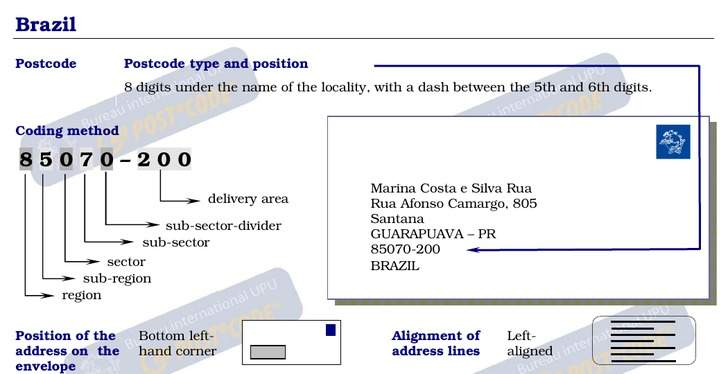

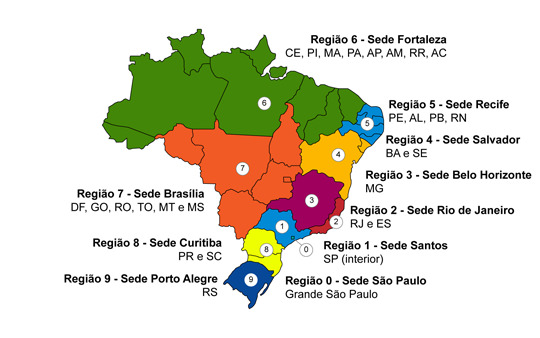

In [52]:
'''
NON UTILISE ON GARDE LES COORDONNES GPS !!!

# Encodage pour chaque region on pourra également récupérer les sommes
# pour chaque localisation des client. Idem pour seller


#encodage pour seller
dfTot['area_seller'] = dfTot['customer_zip_code_prefix']

for i in range(dfTot.shape[0]):
    c = str(dfTot['area_seller'].iloc[i])
    if len(c) == 4:
        dfTot['area_seller'].iloc[i] = 'areaSeller0'
    else:
        dfTot['area_seller'].iloc[i] = "areaSeller" + c[0]

# HotOneEncoding sur 'area_seller'
dfc = pd.get_dummies(dfTot['area_seller'])
for col in dfc:
    dfc[col] = dfc[col]*dfTot['payment_value']
dfTot = pd.concat([dfTot, dfc], axis=1)
del(dfTot['area_seller'])# devenu inutile

'''
# encodage pour customer
dfTot['area_cust'] = dfTot['customer_zip_code_prefix']

for i in range(dfTot.shape[0]):
    c = str(dfTot['area_cust'].iloc[i])
    if len(c) == 4:
        dfTot['area_cust'].iloc[i] = 'sao paulo'
    elif c[0] == '1':
        dfTot['area_cust'].iloc[i] = "santos"
    elif c[0] == '2':
        dfTot['area_cust'].iloc[i] = "rio de janeiro"
    elif c[0] == '3':
        dfTot['area_cust'].iloc[i] = "bello horizonte"
    elif c[0] == '4':
        dfTot['area_cust'].iloc[i] = "salvador"
    elif c[0] == '5':
        dfTot['area_cust'].iloc[i] = "recife"
    elif c[0] == '6':
        dfTot['area_cust'].iloc[i] = "fortaleza"
    elif c[0] == '7':
        dfTot['area_cust'].iloc[i] = "brasillia"
    elif c[0] == '8':
        dfTot['area_cust'].iloc[i] = "curitiba"
    elif c[0] == '9':
        dfTot['area_cust'].iloc[i] = "porto alegre"

# HotOneEncoding sur 'area_cust'
dfc = pd.get_dummies(dfTot['area_cust'])
for col in dfc:
    dfc[col] = dfc[col]  # dfTot['payment_value']
dfTot = pd.concat([dfTot, dfc], axis=1)
del(dfTot['area_cust'])  # devenu inutile
del(dfTot['customer_zip_code_prefix'])  # devenu inutile

/home/sylvain/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# On filtre par client

In [53]:
# on renome les colonnes
dfTot = dfTot.rename(columns={'order_id': 'number_order',
                              'order_purchase_timestamp': 'meantime_purchase',
                              'delivery_time': 'meantime_delivery',
                              'delivery_delay': 'meantime_delay',
                              'order_item_id': 'total_item',
                              'product_id': 'total_product',
                              'price': 'mean_price',
                              'product_weight_g': 'masse',
                              'freight_value': 'mean_freight',
                              'payment_value': 'total_price'})

In [64]:
# dictionnaire d'aggrégation
dict_agg = {'dist_customer_seller_km': 'median',
            'geolocation_lat_x': lambda x: x.mode()[0],
            'geolocation_lat_y': lambda x: x.mode()[0],
            'geolocation_lng_x': lambda x: x.mode()[0],
            'geolocation_lng_y': lambda x: x.mode()[0],
            'geolocation_lat_x': lambda x: x.mode()[0],
            'number_order': 'nunique',
            'meantime_purchase': lambda x: (x.max()-x.min())/x.nunique(),
            'meantime_delivery': 'mean',
            'total_item' : 'count',
            'total_product': 'nunique',
            'seller_id' : 'nunique',
            'mean_price' : 'mean',
            'mean_freight': 'mean',
            'masse': 'mean',
            'product_length_cm': 'mean',
            'product_width_cm': 'mean',
            'product_height_cm': 'mean',
            'volume': 'mean',
            'description': lambda x: x.mode()[0],
            'total_price': 'sum',
            'review_score': lambda x: x.mode()[0],
            'art': 'sum',
            'animal': 'sum',
            'health': 'sum',
            'auto': 'sum',
            'build': 'sum',
            'computer': 'sum',
            'fashion': 'sum',
            'food': 'sum',
            'home': 'sum',
            'industry': 'sum',
            'toys': 'sum',
            'santos': 'max',
            'rio de janeiro': 'max',
            'bello horizonte': 'max',
            'salvador': 'max',
            'recife': 'max',
            'fortaleza': 'max',
            'brasillia': 'max',
            'curitiba': 'max',
            'porto alegre': 'max',
            'sao paulo': 'max'}

'''
NON UTILISE
            'boleto': 'sum',
            'credit_card': 'sum',
            'debit_card': 'sum',
            'voucher': 'sum'
            'areaCust0': 'max',
            'areaCust1': 'max',
            'areaCust2': 'max',
            'areaCust3': 'max',
            'areaCust4': 'max',
            'areaCust5': 'max',
            'areaCust6': 'max',
            'areaCust7': 'max',
            'areaCust8': 'max',
            'areaCust9': 'max', 
            'areaSeller0': 'max',
            'areaSeller1': 'max',
            'areaSeller2': 'max',
            'areaSeller3': 'max',
            'areaSeller4': 'max',
            'areaSeller5': 'max',
            'areaSeller6': 'max',
            'areaSeller7': 'max',
            'areaSeller8': 'max',
            'areaSeller9': 'max',
'''

"\nNON UTILISE\n            'boleto': 'sum',\n            'credit_card': 'sum',\n            'debit_card': 'sum',\n            'voucher': 'sum'\n            'areaCust0': 'max',\n            'areaCust1': 'max',\n            'areaCust2': 'max',\n            'areaCust3': 'max',\n            'areaCust4': 'max',\n            'areaCust5': 'max',\n            'areaCust6': 'max',\n            'areaCust7': 'max',\n            'areaCust8': 'max',\n            'areaCust9': 'max', \n            'areaSeller0': 'max',\n            'areaSeller1': 'max',\n            'areaSeller2': 'max',\n            'areaSeller3': 'max',\n            'areaSeller4': 'max',\n            'areaSeller5': 'max',\n            'areaSeller6': 'max',\n            'areaSeller7': 'max',\n            'areaSeller8': 'max',\n            'areaSeller9': 'max',\n"

ValueError: too many values to unpack (expected 3)

### On aggrege les datas par Client.

In [55]:
# On groupe par client et on applique le dictionnaire d'aggregation
dfTot = dfTot.groupby('customer_unique_id').agg(dict_agg)
dfTot.head(10)

,dist_customer_seller_km,geolocation_lat_x,geolocation_lat_y,geolocation_lng_x,geolocation_lng_y,number_order,meantime_purchase,meantime_delivery,total_item,total_product,seller_id,mean_price,mean_freight,masse,product_length_cm,product_width_cm,product_height_cm,volume,description,total_price,review_score,art,animal,health,auto,build,computer,fashion,food,home,industry,toys,santos,rio de janeiro,bello horizonte,salvador,recife,fortaleza,brasillia,curitiba,porto alegre,sao paulo
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.374936,-23.340235,-22.708702,-46.830140,-47.664701,1,0.0,553930.0,1,1,1,129.90,12.00,1500.0,34.0,32.0,7.0,7616.0,0.886066,141.90,5,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,141.9,0.00,0.0,0,0,0,0,0,0,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,23.950356,-23.559115,-23.490759,-46.787626,-46.583369,1,0.0,283875.0,1,1,1,18.90,8.29,375.0,26.0,18.0,11.0,5148.0,0.761897,27.19,4,0.0,0.0,27.19,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,524.635203,-27.542880,-23.211746,-48.633426,-46.762875,1,0.0,2219624.0,1,1,1,69.00,17.22,1500.0,25.0,35.0,50.0,43750.0,0.876575,86.22,3,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,86.22,0.0,0,0,0,0,0,0,0,1,0,0
0000f6ccb0745a6a4b88665a16c9f078,2482.134436,-1.312214,-23.543150,-48.483159,-46.490101,1,0.0,1734804.0,1,1,1,25.99,17.63,150.0,19.0,11.0,5.0,1045.0,0.988318,43.62,4,0.0,0.0,0.00,0.0,0.00,43.62,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,1,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,168.075942,-23.505548,-23.302318,-47.469705,-45.971888,1,0.0,1135394.0,1,1,1,180.00,16.89,6050.0,16.0,11.0,3.0,528.0,0.608063,196.89,5,0.0,0.0,0.00,0.0,0.00,196.89,0.00,0.0,0.0,0.00,0.0,1,0,0,0,0,0,0,0,0,0
0004bd2a26a76fe21f786e4fbd80607f,28.285901,-23.515676,-23.700198,-46.688233,-46.513128,1,0.0,160767.0,1,1,1,154.00,12.98,3000.0,67.0,41.0,3.0,8241.0,0.797560,166.98,4,0.0,0.0,0.00,0.0,166.98,0.00,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,1
00050ab1314c0e55a6ca13cf7181fecf,103.662482,-22.823421,-23.625475,-47.087193,-46.612000,1,0.0,601896.0,1,1,1,27.99,7.39,300.0,17.0,12.0,4.0,816.0,0.987613,35.38,4,0.0,0.0,0.00,0.0,0.00,35.38,0.00,0.0,0.0,0.00,0.0,1,0,0,0,0,0,0,0,0,0
00053a61a98854899e70ed204dd4bafe,507.953292,-25.431323,-21.112713,-49.279219,-47.790810,1,0.0,1410430.0,2,2,1,191.00,18.59,1133.5,30.5,20.5,24.0,15059.0,0.898370,838.36,1,0.0,0.0,838.36,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0,0,1,0,0
0005e1862207bf6ccc02e4228effd9a0,264.276849,-22.401371,-21.693371,-42.991002,-45.259769,1,0.0,378056.0,1,1,1,135.00,15.12,2250.0,22.0,20.0,15.0,6600.0,0.989136,150.12,4,0.0,0.0,0.00,0.0,0.00,0.00,150.12,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0


### Certaines features seront compliquées a utilisé dans un contexte métier, on ne peut les conserver

In [56]:
# On peut désormais supprimer les coordonnées GPS car on
# la région des clients et la distance entre client
# et vendeur
del(dfTot['geolocation_lat_x'])
del(dfTot['geolocation_lng_x'])
del(dfTot['geolocation_lat_y'])
del(dfTot['geolocation_lng_y'])

# le nombre de produit (nombre de type de produit
# différent) n'est pas une information nécéssaire
# il vaut mieux connaitre la quantité de produit
# acheté avec 'item'.
del(dfTot['total_product'])

# le fret n'est pas simple a interprété
del(dfTot['mean_freight'])

# le volume est une combinaison
# linéaire des dimensions
del(dfTot['product_length_cm'])
del(dfTot['product_width_cm'])
del(dfTot['product_height_cm'])

# le nombre de vendeur auquel un clients a
# recourt semble difficiliment exploitable
del(dfTot['seller_id'])

### Table de correlation pour identifier les correlations trop fortes

In [57]:
# correlation avant feature selection
dfTot.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,dist_customer_seller_km,number_order,meantime_purchase,meantime_delivery,total_item,mean_price,masse,volume,description,total_price,review_score,art,animal,health,auto,build,computer,fashion,food,home,industry,toys,santos,rio de janeiro,bello horizonte,salvador,recife,fortaleza,brasillia,curitiba,porto alegre,sao paulo
dist_customer_seller_km,1.00,-0.01,-0.01,0.40,-0.01,0.08,-0.01,-0.01,0.01,0.04,-0.06,0.01,0.00,0.05,0.01,0.02,0.02,0.01,-0.00,-0.01,0.00,0.02,-0.25,-0.04,-0.04,0.26,0.42,0.54,0.16,-0.04,0.11,-0.37
number_order,-0.01,1.00,0.55,-0.01,0.38,-0.02,-0.01,-0.01,-0.04,0.08,-0.02,0.00,0.02,0.05,0.00,0.01,0.03,0.06,0.01,0.08,0.01,0.03,-0.00,0.01,-0.00,-0.00,-0.00,-0.01,0.00,-0.00,0.00,0.01
meantime_purchase,-0.01,0.55,1.00,-0.01,0.18,-0.01,-0.01,-0.01,-0.04,0.03,-0.01,-0.00,0.01,0.03,0.00,0.01,0.01,0.03,0.00,0.03,0.00,0.02,0.00,0.01,0.00,-0.00,-0.01,-0.01,-0.00,0.00,0.00,0.00
meantime_delivery,0.40,-0.01,-0.01,1.00,-0.01,0.06,0.08,0.07,-0.00,0.03,-0.34,0.01,-0.01,0.01,0.01,0.01,0.01,-0.01,-0.00,0.00,0.03,0.01,-0.14,0.12,-0.02,0.14,0.14,0.20,0.07,0.02,0.07,-0.27
total_item,-0.01,0.38,0.18,-0.01,1.00,-0.05,0.00,0.01,-0.02,0.39,-0.09,0.01,0.04,0.11,0.08,0.16,0.14,0.06,0.05,0.32,0.12,0.07,0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.00,-0.00,0.00,0.01
mean_price,0.08,-0.02,-0.01,0.06,-0.05,1.00,0.35,0.31,0.04,0.35,-0.01,0.20,0.05,0.22,0.07,0.11,0.16,0.05,0.00,0.09,0.04,0.26,-0.02,0.01,0.00,0.01,0.04,0.04,0.02,0.00,-0.00,-0.04
masse,-0.01,-0.01,-0.01,0.08,0.00,0.35,1.00,0.81,0.01,0.16,-0.03,0.04,0.04,0.05,0.04,0.07,0.01,0.01,-0.00,0.15,0.10,0.02,0.01,0.02,0.01,0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.03
volume,-0.01,-0.01,-0.01,0.07,0.01,0.31,0.81,1.00,-0.00,0.14,-0.03,0.04,0.04,0.06,0.03,0.04,0.01,0.00,-0.00,0.14,0.10,0.04,0.02,0.01,-0.00,0.00,-0.01,-0.00,-0.01,-0.00,0.01,-0.02
description,0.01,-0.04,-0.04,-0.00,-0.02,0.04,0.01,-0.00,1.00,0.01,0.00,0.01,-0.01,0.04,0.01,0.01,0.01,-0.02,0.00,0.00,0.01,-0.06,-0.01,-0.01,-0.00,0.00,0.00,0.00,0.00,0.01,-0.00,0.01
total_price,0.04,0.08,0.03,0.03,0.39,0.35,0.16,0.14,0.01,1.00,-0.06,0.08,0.04,0.16,0.25,0.20,0.71,0.04,0.15,0.36,0.32,0.18,-0.01,0.01,-0.00,0.01,0.01,0.02,0.01,0.00,0.00,-0.02


# Test suppression de feature

In [58]:
# Variance Inflation Factor, on va se servir de
# ce coefficient pour selection les features.
# On supprime en réalité les features qui sont
# trop corrélée aux autres.
# Pour cela on supprimer le score obtenu pour
# chaque feature > 2.5
dfTot = dfTot[featureSelect(dfTot)]
dfTot.head()

/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/sylvain/.local/lib/python3.8/site-packages/statsmodels/stat

,number_order,meantime_purchase,meantime_delivery,total_item,mean_price,volume,description,total_price,review_score,art,animal,health,auto,build,computer,fashion,food,home,industry,toys,santos,rio de janeiro,bello horizonte,salvador,recife,fortaleza,brasillia,curitiba,porto alegre
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.0,553930.0,1,129.90,7616.0,0.886066,141.90,5,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,141.9,0.00,0.0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.0,283875.0,1,18.90,5148.0,0.761897,27.19,4,0.0,0.0,27.19,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,1,0.0,2219624.0,1,69.00,43750.0,0.876575,86.22,3,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,86.22,0.0,0,0,0,0,0,0,0,1,0
0000f6ccb0745a6a4b88665a16c9f078,1,0.0,1734804.0,1,25.99,1045.0,0.988318,43.62,4,0.0,0.0,0.00,0.0,0.0,43.62,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0,1,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,0.0,1135394.0,1,180.00,528.0,0.608063,196.89,5,0.0,0.0,0.00,0.0,0.0,196.89,0.0,0.0,0.0,0.00,0.0,1,0,0,0,0,0,0,0,0


In [59]:
# correlation après feature selection
dfTot.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,number_order,meantime_purchase,meantime_delivery,total_item,mean_price,volume,description,total_price,review_score,art,animal,health,auto,build,computer,fashion,food,home,industry,toys,santos,rio de janeiro,bello horizonte,salvador,recife,fortaleza,brasillia,curitiba,porto alegre
number_order,1.00,0.55,-0.01,0.38,-0.02,-0.01,-0.04,0.08,-0.02,0.00,0.02,0.05,0.00,0.01,0.03,0.06,0.01,0.08,0.01,0.03,-0.00,0.01,-0.00,-0.00,-0.00,-0.01,0.00,-0.00,0.00
meantime_purchase,0.55,1.00,-0.01,0.18,-0.01,-0.01,-0.04,0.03,-0.01,-0.00,0.01,0.03,0.00,0.01,0.01,0.03,0.00,0.03,0.00,0.02,0.00,0.01,0.00,-0.00,-0.01,-0.01,-0.00,0.00,0.00
meantime_delivery,-0.01,-0.01,1.00,-0.01,0.06,0.07,-0.00,0.03,-0.34,0.01,-0.01,0.01,0.01,0.01,0.01,-0.01,-0.00,0.00,0.03,0.01,-0.14,0.12,-0.02,0.14,0.14,0.20,0.07,0.02,0.07
total_item,0.38,0.18,-0.01,1.00,-0.05,0.01,-0.02,0.39,-0.09,0.01,0.04,0.11,0.08,0.16,0.14,0.06,0.05,0.32,0.12,0.07,0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.00,-0.00,0.00
mean_price,-0.02,-0.01,0.06,-0.05,1.00,0.31,0.04,0.35,-0.01,0.20,0.05,0.22,0.07,0.11,0.16,0.05,0.00,0.09,0.04,0.26,-0.02,0.01,0.00,0.01,0.04,0.04,0.02,0.00,-0.00
volume,-0.01,-0.01,0.07,0.01,0.31,1.00,-0.00,0.14,-0.03,0.04,0.04,0.06,0.03,0.04,0.01,0.00,-0.00,0.14,0.10,0.04,0.02,0.01,-0.00,0.00,-0.01,-0.00,-0.01,-0.00,0.01
description,-0.04,-0.04,-0.00,-0.02,0.04,-0.00,1.00,0.01,0.00,0.01,-0.01,0.04,0.01,0.01,0.01,-0.02,0.00,0.00,0.01,-0.06,-0.01,-0.01,-0.00,0.00,0.00,0.00,0.00,0.01,-0.00
total_price,0.08,0.03,0.03,0.39,0.35,0.14,0.01,1.00,-0.06,0.08,0.04,0.16,0.25,0.20,0.71,0.04,0.15,0.36,0.32,0.18,-0.01,0.01,-0.00,0.01,0.01,0.02,0.01,0.00,0.00
review_score,-0.02,-0.01,-0.34,-0.09,-0.01,-0.03,0.00,-0.06,1.00,0.00,0.00,-0.01,-0.02,-0.02,-0.03,0.01,0.00,-0.06,-0.03,-0.02,0.04,-0.06,0.01,-0.04,-0.01,-0.03,-0.00,0.01,0.01
art,0.00,-0.00,0.01,0.01,0.20,0.04,0.01,0.08,0.00,1.00,-0.00,-0.02,-0.00,-0.01,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00


# Suppression des outliers

In [60]:
# Suppression des outliers
dfTot = dfTot[(dfTot <= dfTot.quantile(0.99)) &
              (dfTot >= dfTot.quantile(0.01))]
dfTot = dfTot.dropna(how='any', axis=0)
dfTot.shape

(75803, 29)

### Enregistrements X et dfTot

In [61]:
with open('/home/sylvain/Bureau/Sylvain/reconversion_Machine_learning/Project_3/X', 'wb') as file:
    myPickler = pck(file)
    myPickler.dump(dfTot)

1:80: E501 line too long (98 > 79 characters)
